 Есть две таблички. В первой – юзеры, пришедшие в феврале с Apple Search Ads, и их покупки. Во второй – косты по Apple Search Ads в разрезе кампаний. 

Задача: 
- Найти, как минимум, две кампании, в рамках которых происходило что-то странное, и попробовать объяснить причину.
- Найти три наиболее прибыльные кампании и три наиболее убыточные.
- В разрезе US кампании проанализировать пользователей и найти какие-либо закономерности.

In [40]:
# импортируем библиотеки

import pandas as pd
from pandasql import sqldf 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


In [41]:
# импортируем данные

users = pd.read_csv('/Users/aleksandraluneva/Desktop/windy app/users_asa_feb_flitered.csv')
costs = pd.read_csv('/Users/aleksandraluneva/Desktop/windy app/costs_asa_campaign_filtered.csv')

In [42]:
# проверяем типы данных

users.dtypes

user_id          object
lang             object
pro               int64
product          object
price           float64
sail              int64
kite              int64
wind              int64
surf              int64
fish              int64
snow              int64
other             int64
source           object
campaign         object
install_date     object
dtype: object

In [43]:
costs.dtypes

Date        object
Campaign    object
Cost        object
dtype: object

In [44]:
# корректируем тип данных по расходам в таблице Costs

costs['Cost'] = [
    float(
        str(value).replace(',', '.') # 👈️ period as decimal
    )
    for value in costs['Cost']
]

In [66]:
# объединяем наши таблицы и делаем дополнительные колонки - здесь используем синтаксис SQL для демонстрации умения

q = """ SELECT 
costs.campaign, 
campaign_cost, 
users_per_campaign, 
campaign_cost/users_per_campaign as CPA, 
campaign_cost/pro_per_campaign as CPO, 
pro_per_campaign, 
round(pro_per_campaign/users_per_campaign * 100, 2) as conversion_to_pro, 
campaign_revenue, 
campaign_revenue - campaign_cost as profit_per_campaign, 
round((campaign_revenue - campaign_cost) / campaign_cost * 100,2) as ROMI
FROM
(SELECT campaign, sum(cost) as campaign_cost
FROM costs 
GROUP BY campaign) costs
LEFT JOIN (SELECT campaign, CAST(count(user_id) as float) as users_per_campaign, CAST (count(pro) FILTER (WHERE pro != 0) as integer) as pro_per_campaign, SUM(price) as campaign_revenue
FROM users 
GROUP BY campaign) revenue
ON costs.campaign = revenue.campaign """

In [70]:
# присвоим имя датафрейму

df = sqldf(q)


In [47]:
# проверим отсутствующие значения

df.isna().sum()

campaign                0
campaign_cost           0
users_per_campaign      2
CPA                     2
CPO                    64
pro_per_campaign        2
conversion_to_pro       2
campaign_revenue       67
profit_per_campaign    67
ROMI                   67
dtype: int64

In [71]:
# заполним отсутствующие значения нулями

df = df.fillna(0)
df.isna().sum()

campaign               0
campaign_cost          0
users_per_campaign     0
CPA                    0
CPO                    0
pro_per_campaign       0
conversion_to_pro      0
campaign_revenue       0
profit_per_campaign    0
ROMI                   0
dtype: int64

In [49]:
df.dtypes

campaign                object
campaign_cost          float64
users_per_campaign     float64
CPA                    float64
CPO                    float64
pro_per_campaign       float64
conversion_to_pro      float64
campaign_revenue       float64
profit_per_campaign    float64
ROMI                   float64
dtype: object

В нашем общем датафрейме теперь присутствует следующая информация:

1. campaign - рекламная кампания
2. campaign_cost - расходы на рекламную кампанию
3. users_per_campaign - количество пользователей, пришедших с кампании и установивших приложение
4. CPA - стоимость привлеченного пользователя в рамках кампании
5. CPO - стоимость привлеченного в рамках кампании пользователя, который оформил подписку pro (в том числе пробную бесплатную)
6. pro_per_campaign - количество пользователей на кампанию, оформивших подписку pro (в том числе пробную бесплатную)
7. conversion_to_pro - конверсия в подписку pro (в том числе пробную бесплатную)
8. campaign_revenue - доход с кампании
9. profit_per_campaign - прибыль с кампании
10. ROMI - окупаемость средств, вложенных в кампанию

ЗАДАЧА 1

Найти, как минимум, две кампании, в рамках которых происходило что-то странное, и попробовать объяснить причину. 

In [50]:
# опишем наши данные

df.describe()

,campaign_cost,users_per_campaign,CPA,CPO,pro_per_campaign,conversion_to_pro,campaign_revenue,profit_per_campaign,ROMI
count,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000,107.000000
mean,88.966916,58.953271,1.591515,14.498071,2.280374,2.387664,148.598131,71.040187,125.752991
std,363.603989,155.260911,2.068966,27.246250,9.561908,5.627113,800.655920,451.764000,432.553802
min,0.160000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-111.300000,-56.660000
25%,6.640000,6.500000,0.543312,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15.530000,15.000000,1.047500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,55.620000,47.000000,1.759327,20.212143,1.000000,3.090000,55.000000,16.485000,20.890000
max,3487.890000,1219.000000,13.000000,148.350000,93.000000,50.000000,8110.000000,4622.110000,3471.430000


In [51]:
# проверим, были ли кампании, которые не принесли ни одного пользователя

df.query('users_per_campaign == 0') 

,campaign,campaign_cost,users_per_campaign,CPA,CPO,pro_per_campaign,conversion_to_pro,campaign_revenue,profit_per_campaign,ROMI
51,KH SKAG,0.59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59,MO Discovery,1.44,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [73]:
# выведем кампанию с минимальным показателем прибыли 

min_profit = df.loc[df['profit_per_campaign'].idxmin()]
print(min_profit)

campaign               FR Common_
campaign_cost               406.3
users_per_campaign          461.0
CPA                      0.881345
CPO                     67.716667
pro_per_campaign              6.0
conversion_to_pro             1.3
campaign_revenue            295.0
profit_per_campaign        -111.3
ROMI                       -27.39
Name: 29, dtype: object


In [75]:
# выведем кампанию с максимальным показателем прибыли 

max_profit = df.loc[df['profit_per_campaign'].idxmax()]
print(max_profit)

campaign               US Common_
campaign_cost             3487.89
users_per_campaign         1219.0
CPA                      2.861272
CPO                     37.504194
pro_per_campaign             93.0
conversion_to_pro            7.63
campaign_revenue           8110.0
profit_per_campaign       4622.11
ROMI                       132.52
Name: 100, dtype: object


In [76]:
# выведем кампанию с минимальным показателем ROMI

min_romi = df.loc[df['ROMI'].idxmin()]
print(min_romi)

campaign                GR SKAG
campaign_cost            115.36
users_per_campaign         47.0
CPA                    2.454468
CPO                      115.36
pro_per_campaign            1.0
conversion_to_pro          2.13
campaign_revenue           50.0
profit_per_campaign      -65.36
ROMI                     -56.66
Name: 31, dtype: object


In [77]:
# выведем кампанию с максимальным показателем прибыли 

max_romi = df.loc[df['ROMI'].idxmax()]
print(max_romi)

campaign                KZ SKAG
campaign_cost               1.4
users_per_campaign         13.0
CPA                    0.107692
CPO                         1.4
pro_per_campaign            1.0
conversion_to_pro          7.69
campaign_revenue           50.0
profit_per_campaign        48.6
ROMI                    3471.43
Name: 56, dtype: object


In [78]:
# выведем кампанию с максимальным показателем CPA

max_CPA = df.loc[df['CPA'].idxmax()]
print(max_CPA)

campaign               AU_product_page
campaign_cost                     13.0
users_per_campaign                 1.0
CPA                               13.0
CPO                                0.0
pro_per_campaign                   0.0
conversion_to_pro                  0.0
campaign_revenue                   0.0
profit_per_campaign                0.0
ROMI                               0.0
Name: 7, dtype: object


In [79]:
# в рамках исследования данных мы также хотели бы посмотреть структуру покупки платных подписок по кампаниям

if_trial = """ SELECT
campaign, pro_per_campaign, trial_count, round(trial_count/pro_per_campaign * 100, 2) as trial_share
FROM
(SELECT 
campaign,
CAST (count(pro) FILTER (WHERE pro != 0) as integer) as pro_per_campaign,
CAST (count(product) FILTER (WHERE product LIKE '%trial7d%') as float) as trial_count 
FROM users 
GROUP BY campaign) t2
WHERE pro_per_campaign !=0
ORDER BY trial_share asc """

In [58]:
# в рамках исследования данных мы также хотели бы посмотреть структуру покупки платных подписок по кампаниям

sqldf(if_trial)

,campaign,pro_per_campaign,trial_count,trial_share
0,AU Discovery,2,0.0,0.00
1,CA Common_,7,0.0,0.00
2,CH Common_,2,0.0,0.00
3,ID SKAG,1,0.0,0.00
4,MX Discovery,1,0.0,0.00
5,VN Discovery,1,0.0,0.00
6,IT Common_,4,1.0,25.00
7,FR Common_,6,2.0,33.33
8,UK Common_,12,4.0,33.33
9,DK SKAG,2,1.0,50.00


ВЫВОДЫ (ЗАДАЧА 1):

1. 2 кампании не принесли ни одного пользователя - KH SKAG, MO Discovery. Причины могут быть в нецелевой аудитории, неэффективной стратегии, сезонности.
2. KZ SKAG - кампания с самым высоким ROMI (значительно выше среднего) и низким CPA. Вероятно, кампания была нацелена на очень узкую и хорошо определенную аудиторию, которая действительно заинтересована в продукте. Также вероятно, был использован очень эффективный креатив, правильные каналы продвижения.
3. AU_product_page - кампания с самым высоким CPA. Возможно, неправильное таргетирование аудитории, недостаточное качество креатива.
4. US Common_ - самая высокая прибыль при CPA выше среднего. Такая ситуация может быть обусловлена качественным таргетингом, лояльностью, уникальным преимуществом, качественным и дорогим контентом, дорогой рекламой. Стоит проанализировать все факторы, влияющие на производительность кампании, чтобы понять, какие факторы способствуют высокой прибыли и какие могут быть оптимизированы для улучшения ROMI и снижения CPA. 
5. FR Common_ - убыточная с отрицательной прибылью. GR SKAG - компания с самым низким ROMI. Причины могут быть в нецелевой аудитории, неэффективной стратегии.

БОНУС ВЫВОД:

В рамках исследования данных мы также посмотрели структуру покупки платных подписок по кампаниям. Доля установки пробных подписок у следующих кампаний ниже 50%:
AU Discovery, CA Common_, CH Common_, ID SKAG, MX Discovery, VN Discovery, IT Common_, FR Common_, UK Common_

Рекомендуется внимательно изучить эти кампании, чтобы понять, что стимулирует новых пользователей сразу оформлять платную подписку.

ЗАДАЧА 2

Найти три наиболее прибыльные кампании и три наиболее убыточные.

In [59]:
# три наиболее прибыльные кампании - кампании с самым высоким ROMI

df.sort_values('ROMI', ascending=False).head(3)

,campaign,campaign_cost,users_per_campaign,CPA,CPO,pro_per_campaign,conversion_to_pro,campaign_revenue,profit_per_campaign,ROMI
56,KZ SKAG,1.40,13.0,0.107692,1.400,1.0,7.69,50.0,48.60,3471.43
71,PE Discovery,2.65,2.0,1.325000,2.650,1.0,50.00,50.0,47.35,1786.79
97,UAE Common_,6.51,20.0,0.325500,3.255,2.0,10.00,100.0,93.49,1436.10


In [60]:
# три наиболее убыточные кампании - кампании с самым низким ROMI

df.sort_values('ROMI', ascending=True).head(3)

,campaign,campaign_cost,users_per_campaign,CPA,CPO,pro_per_campaign,conversion_to_pro,campaign_revenue,profit_per_campaign,ROMI
31,GR SKAG,115.36,47.0,2.454468,115.36,1.0,2.13,50.0,-65.36,-56.66
77,PL Discovery,80.78,56.0,1.442500,80.78,1.0,1.79,50.0,-30.78,-38.10
49,JP Common_,148.35,192.0,0.772656,148.35,1.0,0.52,100.0,-48.35,-32.59


ВЫВОДЫ (ЗАДАЧА 2):

1. Три наиболее прибыльные кампании - кампании с самым высоким ROMI - KZ SKAG, PE Discovery, UAE Common_

2. Три наиболее убыточные кампании - кампании с самым низким ROMI - GR SKAG, PL Discovery, JP Common_

ЗАДАЧА 3

В разрезе US кампании проанализировать пользователей и найти какие-либо закономерности

In [61]:
# выберем соответствующие кампании

df.query('campaign.str.contains("US")', engine='python')

,campaign,campaign_cost,users_per_campaign,CPA,CPO,pro_per_campaign,conversion_to_pro,campaign_revenue,profit_per_campaign,ROMI
100,US Common_,3487.89,1219.0,2.861272,37.504194,93.0,7.63,8110.0,4622.11,132.52
101,US Search Tab_Return,30.21,3.0,10.070000,0.000000,0.0,0.00,0.0,0.00,0.00
102,US_prod_page,8.75,2.0,4.375000,0.000000,0.0,0.00,0.0,0.00,0.00


In [62]:
# проанализируем на каком языке говорит большинство пользователей и какие активности предпочитают
# создадим отдельный датафрейм из таблицы users

US = """ SELECT *
from users
WHERE campaign LIKE 'US%'
"""
us_df = sqldf(US)

In [63]:
# на каком языке говорит большинство пользователей

language = us_df.groupby('lang').size() / len(us_df)
language = language.sort_values(ascending=False)
language = language.apply(lambda x: '{:.2f}%'.format(x*100))
print(language)

lang
en_US                       87.25%
en_IR@calendar=gregorian     1.14%
es_US                        1.06%
en_IQ                        0.65%
en_SA@calendar=gregorian     0.57%
                             ...  
en_MX                        0.08%
en_NA                        0.08%
en_PH                        0.08%
en_AE                        0.08%
en_PK                        0.08%
Length: 72, dtype: object


In [64]:
us_interest = us_df[['sail', 'kite', 'wind', 'surf', 'fish', 'snow', 'other']].sum().to_frame().rename(columns={0: 'Total'})
us_interest = us_interest.sort_values(by='Total', ascending=False).rename_axis('Activity')
print(us_interest)

          Total
Activity       
other       348
fish        308
sail        230
surf        102
snow         74
kite         29
wind         29


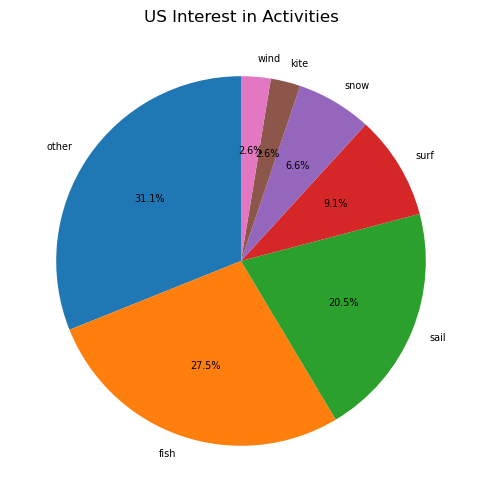

In [65]:
# Создание круговой диаграммы
labels = us_interest.index
sizes = us_interest['Total']
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, textprops={'fontsize': 7})
ax.set_title('US Interest in Activities')
plt.show()

ВЫВОДЫ (ЗАДАЧА 3):

1. Большинство пользователей (87.25%) англоговорящие американцы. Топ-3 языков выглядит так:
- en_US                       87.25%
- en_IR@calendar=gregorian     1.14%
- es_US                        1.06%

2. Топ-3 интересов, помимо категории "Other" составляют рыболовы, любители яхтинга и серферы:
- other       348
- fish        308
- sail        230
- surf        102

![![output.png](https://)](attachment:output.png)

3. Кампания US Common_ оказалась самой прибыльной в Соединенных Штатах:
Она имеет довольно высокую конверсию в подписку (включая траял) - 7.63% и неплохой показатель ROMI - 132.52%.

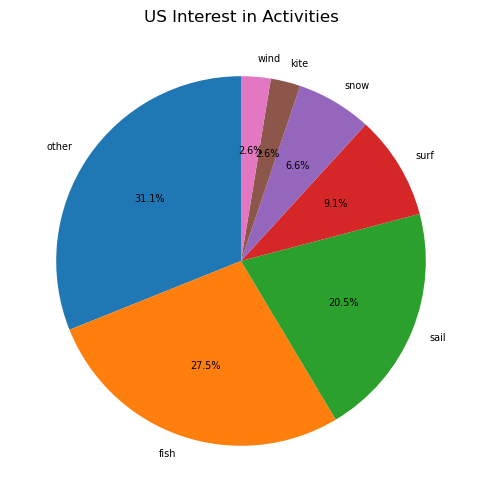